In [1]:
import torch
import tensorflow as tf
from torch.utils.data import TensorDataset , DataLoader, RandomSampler , SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel, BertConfig
from transformers import BertForSequenceClassification, get_linear_schedule_with_warmup

In [2]:
import pandas as pd 
import io 
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
pd.set_option('max_colwidth', 400)
pd.set_option('display.max_columns', None)

In [3]:
train_data = pd.read_csv('csv_files/train_sent_emo.csv')
val_data = pd.read_csv('csv_files/dev_sent_emo.csv')
test_data = pd.read_csv('csv_files/test_sent_emo.csv')

In [4]:
train_data['Utterance'] = train_data['Utterance'].str.replace('\x92', "'", regex=False)
val_data['Utterance'] = val_data['Utterance'].str.replace('\x92', "'", regex=False)
test_data['Utterance'] = test_data['Utterance'].str.replace('\x92', "'", regex=False)

## Seperating text and targets

In [5]:
train_sentences=train_data.Utterance.values
train_labels=train_data.Emotion.values

dev_sentences=val_data.Utterance.values
dev_labels=val_data.Emotion.values

In [6]:
# Encode labels
from sklearn.preprocessing import OrdinalEncoder
encoder=OrdinalEncoder()
train_labels=encoder.fit_transform(train_labels.reshape(-1,1))
dev_labels=encoder.transform(dev_labels.reshape(-1,1))

## Tokenization

In [7]:
tokenizer=BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_train_texts=[tokenizer.tokenize(sent) for sent in train_sentences]
tokenized_dev_texts=[tokenizer.tokenize(sent) for sent in dev_sentences]

In [8]:
max_len=0
for i in tokenized_train_texts:
    if len(i)>max_len:
        max_len=len(i)
print(max_len)

93


In [9]:
MAX_LEN=128

## Numericalization

In [10]:
input_ids_train=[tokenizer.convert_tokens_to_ids(x) for x in tokenized_train_texts]
print(tokenized_train_texts[5])
print(input_ids_train[5])

['now', 'you', "'", 'll', 'be', 'heading', 'a', 'whole', 'division', ',', 'so', 'you', "'", 'll', 'have', 'a', 'lot', 'of', 'duties', '.']
[2085, 2017, 1005, 2222, 2022, 5825, 1037, 2878, 2407, 1010, 2061, 2017, 1005, 2222, 2031, 1037, 2843, 1997, 5704, 1012]


In [11]:
input_ids_dev=[tokenizer.convert_tokens_to_ids(x) for x in tokenized_dev_texts]
print(tokenized_dev_texts[0])
print(input_ids_dev[0])

['oh', 'my', 'god', ',', 'he', "'", 's', 'lost', 'it', '.', 'he', "'", 's', 'totally', 'lost', 'it', '.']
[2821, 2026, 2643, 1010, 2002, 1005, 1055, 2439, 2009, 1012, 2002, 1005, 1055, 6135, 2439, 2009, 1012]


In [12]:
input_ids_train=pad_sequences(input_ids_train, maxlen=MAX_LEN, dtype='long',truncating='post', padding='post')
input_ids_dev=pad_sequences(input_ids_dev, maxlen=MAX_LEN, dtype='long',truncating='post', padding='post')

## Creating attention masks

In [13]:


train_attention_masks=[]
for seq in input_ids_train:
    train_seq_mask=[float(i>0) for i in seq]
    train_attention_masks.append(train_seq_mask)

dev_attention_masks=[]
for seq in input_ids_dev:
    dev_seq_mask=[float(i>0) for i in seq]
    dev_attention_masks.append(dev_seq_mask)



## To Tensors

In [14]:
input_train=torch.tensor(input_ids_train, dtype=torch.long)
input_val=torch.tensor(input_ids_dev, dtype=torch.long)
label_train=torch.tensor(train_labels, dtype=torch.long)
label_val=torch.tensor(dev_labels, dtype=torch.long)
mask_train=torch.tensor(train_attention_masks, dtype=torch.float)
mask_val=torch.tensor(dev_attention_masks, dtype=torch.float)

## Batching and Iterator

In [15]:
train_data=TensorDataset(input_train, mask_train, label_train)
val_data=TensorDataset(input_val, mask_val ,label_val)

train_sampler=RandomSampler(train_data)
train_dataloader=DataLoader(train_data, sampler=train_sampler, batch_size=32)
val_sampler=RandomSampler(val_data)
val_dataloader=DataLoader(val_data, sampler=val_sampler, batch_size=32)

## Model configuration

In [16]:
configuration=BertConfig()
model=BertModel(configuration)

In [17]:
print(model.config)

BertConfig {
  "_attn_implementation_autoset": true,
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.51.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



## Loading Pretrained Model

In [18]:
# Load BERT for sequence classification 
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=7)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Parameter Optimization

In [19]:
param_optimizer=list(model.named_parameters())
no_decay=['bias', 'LayerNorm.weight']
optimizer_grouped_parameters=[
    {'params': [p for n,p in param_optimizer if not any(nd in n for nd in no_decay)],
    'weight_decay_rate': 0.1,},
    {'params':[p for n,p in param_optimizer if any(nd in n for nd in no_decay)],
    'weight_decay_rate':0.0}
]

In [20]:
optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=1e-5)

In [21]:
from sklearn.metrics import f1_score

def flat_accuracy(preds,labels):
    pred_flat=np.argmax(preds,axis=1).flatten()
    labels_flat=labels.flatten()
    return np.sum(pred_flat==labels_flat) /len(labels_flat)

def get_f1_score(preds, labels):
    pred_flat=np.argmax(preds,axis=1).flatten()
    labels_flat=labels.flatten()
    return f1_score(labels_flat, pred_flat, average="weighted")

## Train Loop

In [22]:
# import torch
# torch.manual_seed(1)
# import random
# random.seed(1)
# import numpy as np
# np.random.seed(1)
# import copy

# epochs=6
# total_steps=len(train_dataloader) *epochs
# scheduler=get_linear_schedule_with_warmup(optimizer,
#                                          num_warmup_steps=0,
#                                          num_training_steps=total_steps)

# t=[]
# train_loss_set=[]
# for _ in trange(epochs, desc="Epoch"):
#     model.cuda()
#     model.train()
#     tr_loss=0
#     nb_tr_examples, nb_tr_steps=0,0
    
#     for step,batch in enumerate(train_dataloader):
#         batch=tuple(t.to('cuda') for t in batch)
#         b_input_ids,b_input_mask, b_labels=batch
#         optimizer.zero_grad()
#         outputs=model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
#         loss=outputs['loss']
#         train_loss_set.append(loss.item())
#         loss.backward()
#         optimizer.step()
#         scheduler.step()

#         tr_loss+=loss.item()
#         nb_tr_examples+=b_input_ids.size(0)
#         nb_tr_steps+=1
#     print("train loss: {}".format(tr_loss/nb_tr_steps))    

#     model.eval()
#     eval_los, eval_f1=0,0
#     nb_eval_steps, nb_eval_examples=0,0
    
#     for batch in val_dataloader:
#         batch=tuple(t.to('cuda') for t in batch)        
#         b_input_ids,b_input_mask, b_labels=batch
        
#         with torch.no_grad():
#             logits=model(b_input_ids,token_type_ids=None, attention_mask=b_input_mask)
        
#         logits=logits['logits'].detach().cpu().numpy()
#         label_ids=b_labels.to('cpu').numpy()
        
#         tmp_eval_f1=get_f1_score(logits,label_ids)
#         eval_f1+=tmp_eval_f1
#         nb_eval_steps+=1

#     print("f1: {}".format(eval_f1/nb_eval_steps))


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 1 train loss: 1.3938


Epoch:  10%|█         | 1/10 [01:22<12:20, 82.28s/it]

F1 score: 0.3024
New best F1. Model state saved.

Epoch 2 train loss: 1.1788


Epoch:  20%|██        | 2/10 [02:43<10:52, 81.59s/it]

F1 score: 0.3554
New best F1. Model state saved.

Epoch 3 train loss: 1.0775


Epoch:  30%|███       | 3/10 [04:04<09:29, 81.40s/it]

F1 score: 0.3577
New best F1. Model state saved.

Epoch 4 train loss: 0.9863


Epoch:  40%|████      | 4/10 [05:26<08:09, 81.52s/it]

F1 score: 0.3684
New best F1. Model state saved.

Epoch 5 train loss: 0.9063


Epoch:  50%|█████     | 5/10 [06:47<06:47, 81.51s/it]

F1 score: 0.4096
New best F1. Model state saved.

Epoch 6 train loss: 0.8364


Epoch:  60%|██████    | 6/10 [08:09<05:25, 81.42s/it]

F1 score: 0.4020
No improvement. Early stopping patience: 1/2

Epoch 7 train loss: 0.7577


Epoch:  60%|██████    | 6/10 [09:30<06:20, 95.05s/it]

F1 score: 0.4035
No improvement. Early stopping patience: 2/2
Early stopping triggered.
Restored best model for final evaluation.

Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.36      0.39       153
           1       0.50      0.14      0.21        22
           2       0.00      0.00      0.00        40
           3       0.49      0.58      0.53       163
           4       0.71      0.80      0.75       470
           5       0.45      0.27      0.34       111
           6       0.55      0.66      0.60       150

    accuracy                           0.59      1109
   macro avg       0.45      0.40      0.40      1109
weighted avg       0.56      0.59      0.57      1109



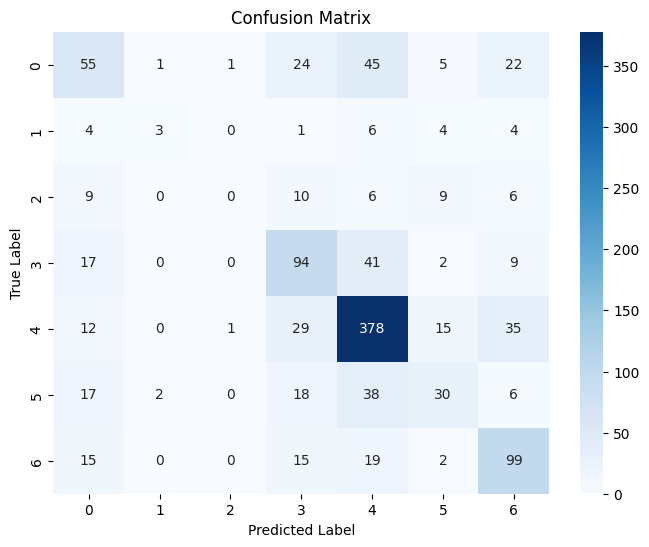

In [23]:
import torch
import random
import numpy as np
import copy
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange

# Reproducibility
torch.manual_seed(1)
random.seed(1)
np.random.seed(1)

epochs = 10
patience = 2
wait = 0
best_f1 = 0
best_model_state = None

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

train_loss_set = []

for epoch in trange(epochs, desc="Epoch"):
    model.cuda()
    model.train()
    tr_loss = 0
    nb_tr_steps = 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to('cuda') for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        optimizer.zero_grad()
        outputs = model(
            b_input_ids,
            token_type_ids=None,
            attention_mask=b_input_mask,
            labels=b_labels
        )
        loss = outputs['loss']
        train_loss_set.append(loss.item())
        loss.backward()
        optimizer.step()
        scheduler.step()

        tr_loss += loss.item()
        nb_tr_steps += 1

    print(f"\nEpoch {epoch + 1} train loss: {tr_loss / nb_tr_steps:.4f}")

    model.eval()
    all_preds = []
    all_labels = []

    for batch in val_dataloader:
        batch = tuple(t.to('cuda') for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(
                b_input_ids,
                token_type_ids=None,
                attention_mask=b_input_mask
            )
        logits = outputs['logits']
        preds = torch.argmax(logits, axis=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(b_labels.cpu().numpy())

    avg_f1 = f1_score(all_labels, all_preds, average='macro')
    print(f"F1 score: {avg_f1:.4f}")

    if avg_f1 > best_f1:
        best_f1 = avg_f1
        wait = 0
        best_model_state = copy.deepcopy(model.state_dict())
        print("New best F1. Model state saved.")
    else:
        wait += 1
        print(f"No improvement. Early stopping patience: {wait}/{patience}")
        if wait >= patience:
            print("Early stopping triggered.")
            break

# Restore best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Restored best model for final evaluation.")

# Final Evaluation
cm = confusion_matrix(all_labels, all_preds)
print("\nClassification Report:\n", classification_report(all_labels, all_preds))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


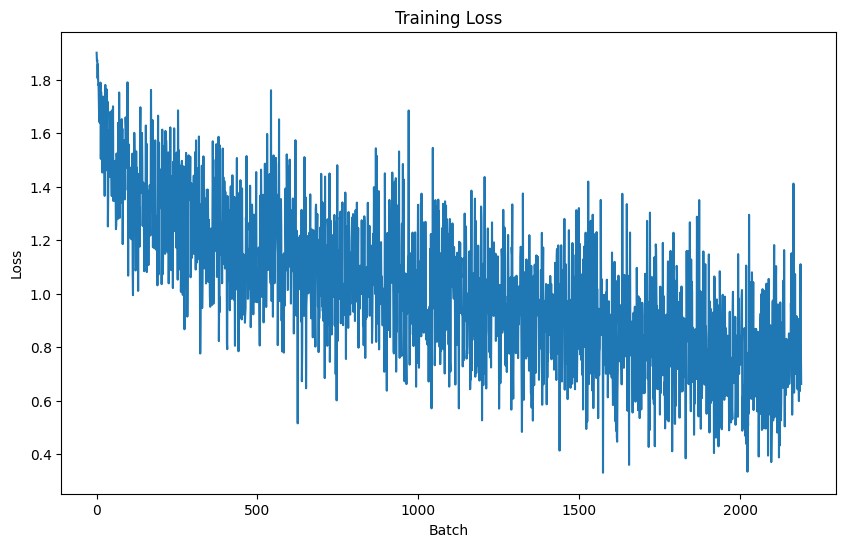

In [24]:
plt.figure(figsize=(10,6))
plt.title("Training Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

F1 score: 0.4096

Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.37      0.40       153
           1       0.60      0.14      0.22        22
           2       0.50      0.03      0.05        40
           3       0.49      0.59      0.53       163
           4       0.71      0.82      0.76       470
           5       0.44      0.24      0.31       111
           6       0.57      0.62      0.59       150

    accuracy                           0.60      1109
   macro avg       0.53      0.40      0.41      1109
weighted avg       0.58      0.60      0.57      1109



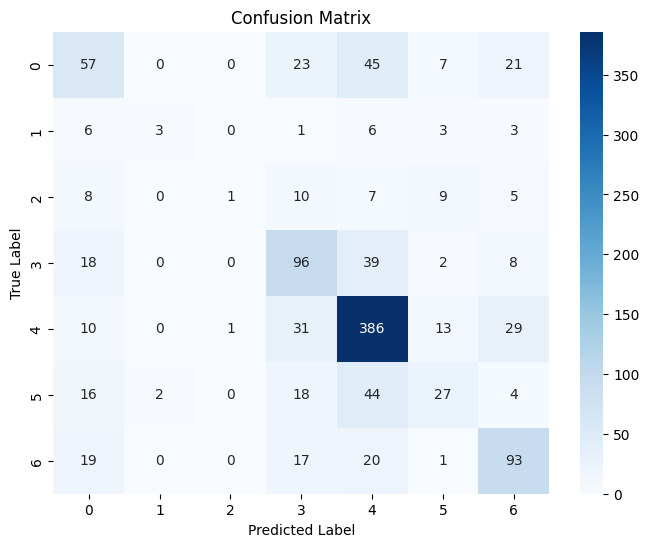

In [25]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report  # Optional: in case get_f1_score uses it

import seaborn as sns

model.eval()
eval_f1 = 0
nb_eval_steps = 0

all_preds = []
all_labels = []

for batch in val_dataloader:
    batch = tuple(t.to('cuda') for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(
            b_input_ids,
            token_type_ids=None,
            attention_mask=b_input_mask
        )

    logits = outputs['logits']
    preds = torch.argmax(logits, axis=1)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(b_labels.cpu().numpy())

# Compute F1
avg_f1 = f1_score(all_labels, all_preds, average='macro')
print(f"F1 score: {avg_f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
print("\nClassification Report:\n", classification_report(all_labels, all_preds))

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=range(cm.shape[0]), yticklabels=range(cm.shape[0]))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [27]:
torch.save(model.state_dict(), "models/bert_model_sentiment_f1_65.ckpt")